In [359]:
#====================IMPORT PACKAGES========================

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')
import matplotlib.patches as patches
import scipy
import numpy as np
import math
from PIL import Image
from spextra import Spextrum
from spextra import SpecLibrary
from spextra import Passband
import astropy.units as u
from svo_filters import svo

In [360]:
#=====================SENSOR PARAMETERS===================== Example: ZWO ASI 6200MM (ROI 40x40 px)

pixel_size = 3.76*10**(-6) #in meters
Q_efficiency = 0.87*0.95 #fraction of incoming photons that elevate electrons in any given pixel by the P.E. effect, accounts for sensor QE = 0.5 , optics transmissivity = 0.95
read_noise = 1.2 #electrons/pixel
gain = 0.779 #electrons/ADU
sensor_offset = 500
dark_noise = 0.005 #electrons/second/pixel
full_well = 51000 #maximum number of electrons
sensor_X = 40 #sensor width in pixels 4007
sensor_Y = 40 #sensor height in pixels 2671

sensor_width = sensor_X*pixel_size #Sensor width in m
sensor_height = sensor_Y*pixel_size #Sensor height in m


In [361]:
#=====================OBSERVATORY PARAMETERS===================== Example: AG Optical FA12 12.5" Harmer Wynne

scope_dia = 0.4318*u.m #telescope diameter in metres
mirror_area = np.pi*(scope_dia/2)**2
scope_focal = 2.9379 #telescope focal length in meters
f_ratio = scope_focal/scope_dia #compute focal ratio of the telescope
plate_scale = 0.26 #arcsec/pixel
pixel_area = plate_scale**2 #arcsec^2


In [362]:
#=====================FILTER PARAMETERS===================== Example: SDSS 'g' filter

filter_low = 495.9*1*10**(-9) # filter lower bound wavelength in meters
filter_low_freq = scipy.constants.c/filter_low

filter_high = 500.7*10**(-9) # filter upper bound wavelength in meters
filter_high_freq = scipy.constants.c/filter_high

filter_zero = 3631 # zero point flux for fitler, Jansky = 10^(-26) W/m^2/Hz
filter_freq_band = filter_low_freq-filter_high_freq

filter_name = 'Gemini/GMOS-N.OIII'

# available filter profiles: https://spextra.readthedocs.io/en/latest/filters.html 
# More filter profiles: https://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Gemini&gname2=GMOS-N&asttype= 


In [363]:
obs_type = 1 # 0 FOR EXTENDED SOURCE, 1 FOR POINT SOURCE --------------------------------------------------------------------------------------------------------------------------------------------

#=====================POINT SOURCE PARAMETERS===================== Example: 16-Lmi

#Star is completely characterized by its temperature, distance and size
#You can use other metrics to completely characterize it if these measurements are unavailable, however they are the most convenient to use

#star_dist = 1487.4 #Lightyears #1487.4
#star_dist_m = star_dist*9.461*10**15 #star distance in meters
star_temp = 7793*u.K #Temperature in Kelvin (for pure Black Body only)
star_mag = 11.6 #Star magnitude in AB magnitudes (If you want to use another magnitude system, define it here and change the bandpass in the stellarSpec function)
mag_type = 'B' #Filter for magnitude scaling. Default is V filter for photosvisual magnituded system.
star_type = 'a0iii' #Spectral classificiaton of stars if using stellarSpec

#=====================EXTENDED SOURCE PARAMETERS===================== Example: NGC 7714

ext_dist = 1500 #distance in lightyears
ext_dist_m = ext_dist*9.461*10**15 #distance in meters
ext_lib = "brown"
ext_class = "NGC7714"

# Available spectral profiles of extended sources: https://spextra.readthedocs.io/en/latest/spectral_libraries.html#

ext_mag = 12.74 # mag/arcsec^2 
ext_mag_type = 'V'

#Source: http://ned.ipac.caltech.edu/byname?objname=NGC+7714&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1


In [364]:
#===================== COMPUTE FOV (arcseconds) =====================

#Using Focal length, pixel size and sensor dimensions
FOV_height = 206265*sensor_height*(1/scope_focal)
FOV_width = 206265*sensor_width*(1/scope_focal)
FOV_area = FOV_width*FOV_height


In [365]:
#===================== SKY PARAMETERS ===================== Example: Animas, NM, USA

sky_bright = 20.87 #sky brightness (mag/arcsec^2) Source: https://www.lightpollutionmap.info/ #20.87 for GAO site
seeing_cond = 4 #seeing condition reported in FWHM (arcsec)
seeing_pixel = seeing_cond/plate_scale #FWHM of star in pixels

In [366]:
def blackBody(starTemp,starMag,mirrorArea,filterName,magFilt):

    blackBodySpec = Spextrum.black_body_spectrum(temperature = starTemp, amplitude = starMag*u.ABmag, filter_curve=magFilt)

    starPhotons = blackBodySpec.photons_in_range(area=mirrorArea,filter_curve=filterName)

    wavelengths = blackBodySpec.waveset
    fluxes = blackBodySpec(wavelengths, flux_unit="PHOTLAM")

    filter = Passband(filterName) 

    filterWLS = filter.waveset
    filterPass = filter(filterWLS)

    # Plot filter transmission curve and black body spectrum

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Wavelength (Å)')
    ax1.set_ylabel('Flux (photons/sec/cm^2/Å)')
    stellarPlot, = ax1.plot(wavelengths, fluxes, label='Stellar Black Body Spectrum',color='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Filter Transmission Coefficient')
    filterPlot, = ax2.plot(filterWLS, filterPass, label= filterName + ' Filter Transmission',color='b')

    plt.title('Filtered Black Body Spectrum')
    plt.xlim(0,25000)
    ax2.set_ylim(0)
    ax1.set_ylim(0)

    plots = [stellarPlot,filterPlot]
    labels = [plot.get_label() for plot in plots]

    ax1.legend(plots,labels,loc='best')
    plt.grid(True) 
    plt.show()

    return starPhotons 
    

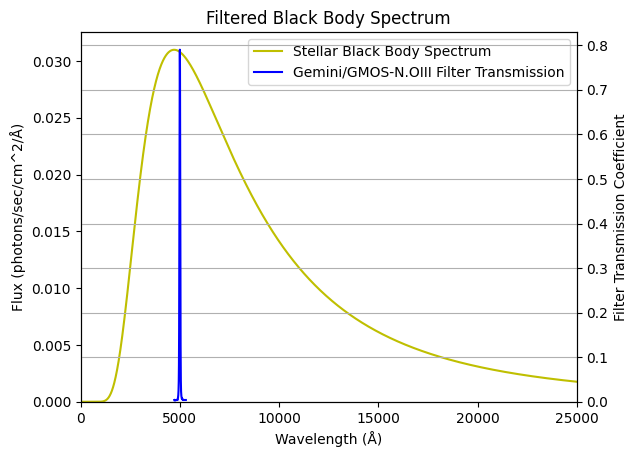

The sensor receives:  1626.89 counts per second from the black body.


In [367]:
print("The sensor receives: ",round((blackBody(star_temp,star_mag,mirror_area,filter_name,mag_type)*Q_efficiency).value,2), "counts per second from the black body.")

In [368]:
def stellarSpec(starClass,starMag,mirrorArea,filterName,magFilt):

    starSpec = Spextrum("pickles/"+starClass).scale_to_magnitude(amplitude = starMag*u.ABmag, filter_curve=magFilt)

    starPhotons = starSpec.photons_in_range(area=mirrorArea,filter_curve=filterName)

    wavelengths = starSpec.waveset
    fluxes = starSpec(wavelengths, flux_unit="PHOTLAM")

    filter = Passband(filterName) 

    filterWLS = filter.waveset
    filterPass = filter(filterWLS)

    # Plot filter transmission curve and stellar spectrum

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Wavelength (Å)')
    ax1.set_ylabel('Flux (photons/sec/cm^2/Å)')
    stellarPlot, = ax1.plot(wavelengths, fluxes, label='Stellar Spectrum',color='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Filter Transmission Coefficient')
    filterPlot, = ax2.plot(filterWLS, filterPass, label= filterName + ' Filter Transmission',color='b')

    plt.title('Filtered Stellar Spectrum')
    plt.xlim(0,25000)
    ax2.set_ylim(0)
    ax1.set_ylim(0)

    plots = [stellarPlot,filterPlot]
    labels = [plot.get_label() for plot in plots]

    ax1.legend(plots,labels,loc='best')
    plt.grid(True) 
    plt.show()


    return starPhotons
    



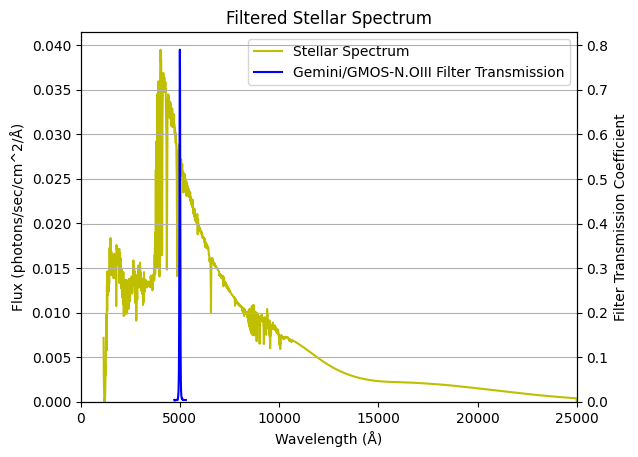

The sensor receives:  1417.33 counts, or 1714.9 photons, per second from the star.


In [369]:
stellar_spec_photons = stellarSpec(star_type,star_mag,mirror_area,filter_name,mag_type)

print("The sensor receives: ",round(stellar_spec_photons.value*Q_efficiency,2), "counts, or", round(stellar_spec_photons.value,1),"photons, per second from the star.")

In [370]:
def extSpec(extClass,extLib,extMag,mirrorArea,filterName,magFilt):

    extSpec = Spextrum(extLib+"/"+extClass).scale_to_magnitude(amplitude = extMag*u.ABmag, filter_curve=magFilt)

    extPhotons = extSpec.photons_in_range(area=mirrorArea,filter_curve=filterName)

    wavelengths = extSpec.waveset
    fluxes = extSpec(wavelengths, flux_unit="PHOTLAM")

    filter = Passband(filterName) 

    filterWLS = filter.waveset
    filterPass = filter(filterWLS)

    # Plot filter transmission curve and stellar spectrum

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Wavelength (Å)')
    ax1.set_ylabel('Flux (photons/sec/cm^2/Å)')

    extLabel = extClass +" Source Spectrum"
    extPlot, = ax1.plot(wavelengths, fluxes, label=extLabel,color='r')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Filter Transmission Coefficient')
    filterPlot, = ax2.plot(filterWLS, filterPass, label= filterName + ' Filter Transmission',color='b')

    plt.title('Filtered Extended Source Spectrum')
    plt.xlim(0,25000)
    ax2.set_ylim(0)
    ax1.set_ylim(0)

    plots = [extPlot,filterPlot]
    labels = [plot.get_label() for plot in plots]

    ax1.legend(plots,labels,loc='best')
    plt.grid(True) 
    plt.show()


    return extPhotons
    



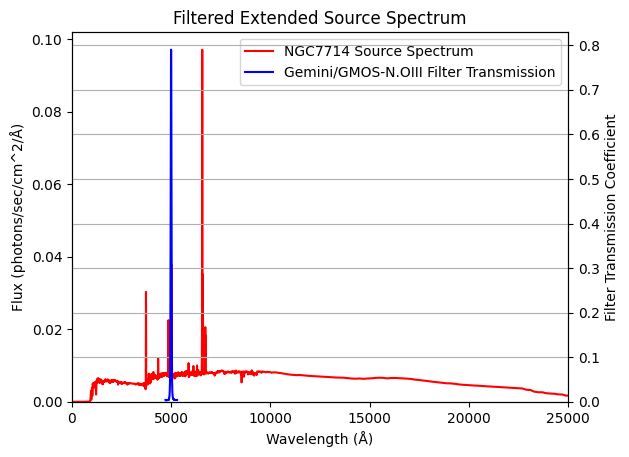

The sensor receives:  44.93 counts per second per pixel from the extended source.


In [371]:
print("The sensor receives: ",round(extSpec(ext_class,ext_lib,ext_mag,mirror_area,filter_name,ext_mag_type).value*Q_efficiency*pixel_area,2),"counts per second per pixel from the extended source.")

In [372]:
#SPREAD POINT SOURCE COUNTS OVER A 2D GAUSSIAN
#Takes in sensor dimensions, total counts TO SPREAD, fwhm (seeing conditions), and full well of the sensor.

def spreadCounts(sensorX, sensorY, totalCounts, fwhm, exposureTime):
    
    x = np.linspace(0,sensorX-1,sensorX)
    y = np.linspace(0,sensorY-1,sensorY)

    X,Y = np.meshgrid(x,y)

    x0 = sensorX/2
    y0 = sensorY/2

    sigma = fwhm/(2*np.sqrt(2*np.log(2)))

    #for x in range(sensorY):
     #   for y in range(sensorX):
      #      signalValues[x,y] = (1/(2*np.pi*sigma**2))*np.exp((-((x-centerX)**2+(y-centerY)**2))/(2*sigma**2))

    signalValues = np.exp(-(((X - x0) ** 2) / (2 * sigma ** 2) + ((Y - y0) ** 2) / (2 * sigma ** 2)))

    signalValues = signalValues*(totalCounts/signalValues.sum())*exposureTime
        
    return signalValues


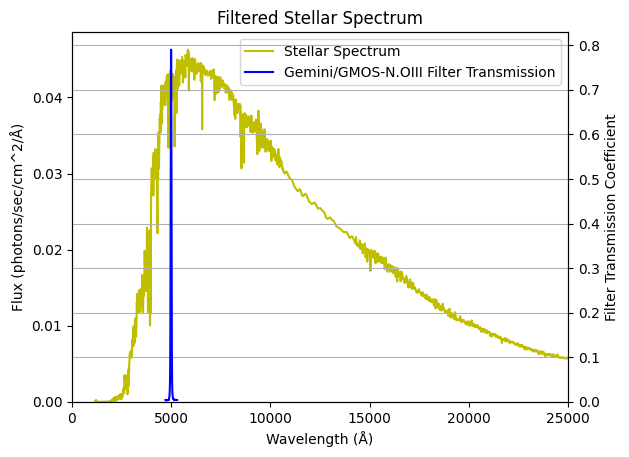

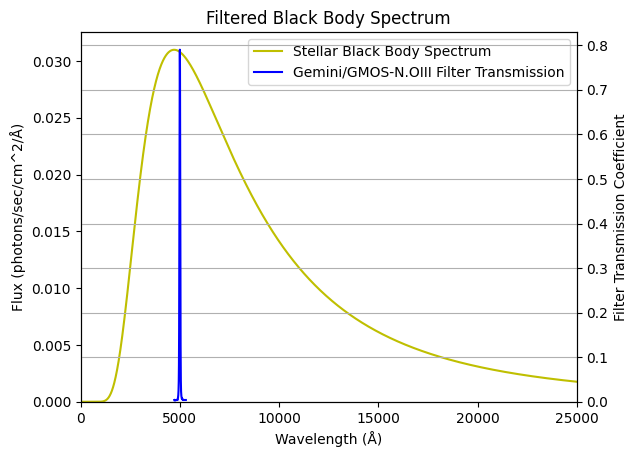

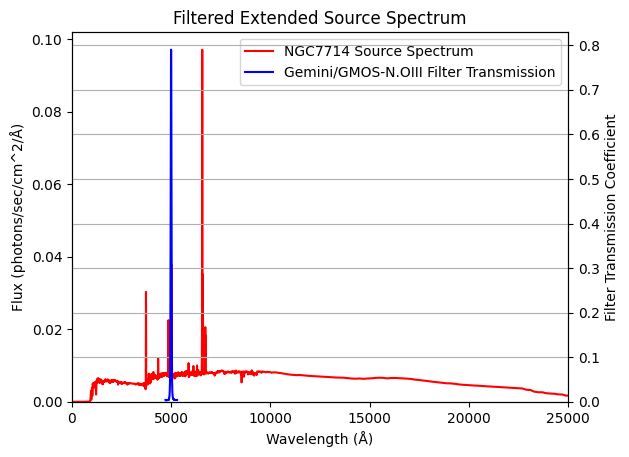

In [373]:
#Assign variables for counts received from blackbody, stellar spectra, or extended source

stellar_Counts = stellarSpec("g2v",star_mag,mirror_area,filter_name,mag_type).value*Q_efficiency

bb_Counts = blackBody(star_temp,star_mag,mirror_area,filter_name,mag_type).value*Q_efficiency

ext_Counts = extSpec(ext_class,ext_lib,ext_mag,mirror_area,filter_name,ext_mag_type).value*Q_efficiency*pixel_area

In [374]:
#Define signal values
#Replace stellar_Counts with bb_Counts for pure black body.

signal_values = spreadCounts(sensor_X,sensor_Y,stellar_Counts,seeing_pixel,1)

test_exposure=1


In [375]:
#GENERATE CCD NOISE
#Takes in sensor parameters and generates signal noise based on exposure time

def generateNoise(sensorX, sensorY, darkCurrent, readNoise, offset, exposureTime, obsType):
    
    if obsType == 1: # Point Source
    
        noiseValues = np.zeros([sensorY,sensorX])
    
        for x in range(sensorY):
            for y in range(sensorX):
                noiseValues[x,y] = np.random.normal(0,readNoise) + np.random.normal(0,darkCurrent)*exposureTime + offset

        return noiseValues
    
    elif obsType == 0: # Extended source

        noiseValues = readNoise + (darkCurrent*exposureTime) + offset
        return noiseValues

In [376]:
noise_values=generateNoise(sensor_X,sensor_Y,dark_noise,read_noise,sensor_offset,test_exposure, obs_type)

In [377]:
#GENERATE SKY BACKGROUND EMISSION

def generateBG(sensorX, sensorY, skyMag, filterName, mirrorArea, sensorGain, sensorQE, pixelArea, obsType):

    bgSpec = Spextrum("pickles/g2v").scale_to_magnitude(amplitude = skyMag*u.ABmag, filter_curve='V')

    bgPhotons = bgSpec.photons_in_range(area=mirrorArea,filter_curve=filterName)

    print("The sensor receives:", bgPhotons.value*sensorGain*sensorQE*pixelArea, "counts per second per pixel due to light pollution.")

    wavelengths = bgSpec.waveset
    fluxes = bgSpec(wavelengths, flux_unit="PHOTLAM")

    filter = Passband(filterName) 

    filterWLS = filter.waveset
    filterPass = filter(filterWLS)

    # Plot filter transmission curve and black body spectrum

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Wavelength (Å)')
    ax1.set_ylabel('Flux (photons/sec/cm^2/Å)')
    bgPlot, = ax1.plot(wavelengths, fluxes, label='Background Sky Emission',color='g')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Filter Transmission Coefficient')
    filterPlot, = ax2.plot(filterWLS, filterPass, label= filterName + ' Filter Transmission',color='b')

    plt.title('Filtered Black Body Spectrum')
    plt.xlim(0,25000)
    ax2.set_ylim(0)
    #ax1.set_ylim(0,0.05)

    plots = [bgPlot,filterPlot]
    labels = [plot.get_label() for plot in plots]

    ax1.legend(plots,labels,loc='best')
    plt.grid(True) 
    plt.show()

    if obsType == 1:

        return bgPhotons.value*sensorGain*sensorQE*pixelArea
    
    elif obsType == 0:

        bgValues = np.zeros([sensorY,sensorX])

        for x in range(sensorY):
            for y in range(sensorX):
                bgValues[x,y] = bgPhotons.value*sensorGain*sensorQE*pixelArea

        return bgValues
        

        

The sensor receives: 0.012025710560836912 counts per second per pixel due to light pollution.


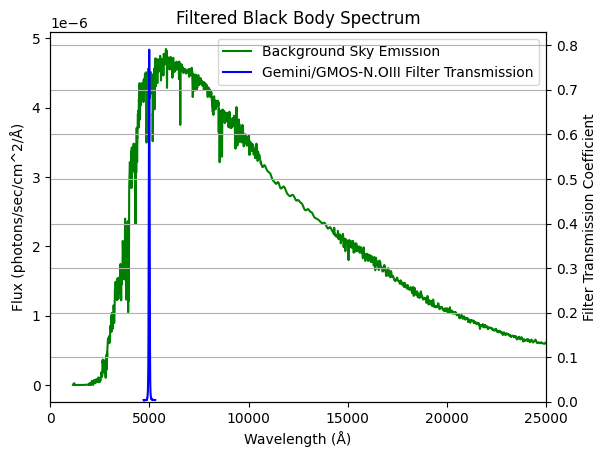

In [378]:
bg_values = generateBG(sensor_X, sensor_Y, sky_bright, filter_name, mirror_area, gain, Q_efficiency, pixel_area, obs_type)*Q_efficiency*pixel_area

In [379]:
#CHECK FOR OVERFULL PIXELS
#Takes in signal, bg noise and sensor noise and checks if any pixels exceed full well. Assumes perfect blooming correction of the sensor

def overfullCheck(arrayTest, fullWell, obsType):

    if obsType == 1: # Point Source

        for x in range(len(arrayTest)):
            for y in range(len(arrayTest[0])):
                if arrayTest[x,y] > fullWell:
                    arrayTest[x,y] = fullWell

        return arrayTest
    
    elif obsType == 0: # Extended Source

        if arrayTest > fullWell:
            arrayTest = fullWell

        return arrayTest

In [380]:
final_sensor_array = overfullCheck(signal_values+noise_values+bg_values,full_well,obs_type)

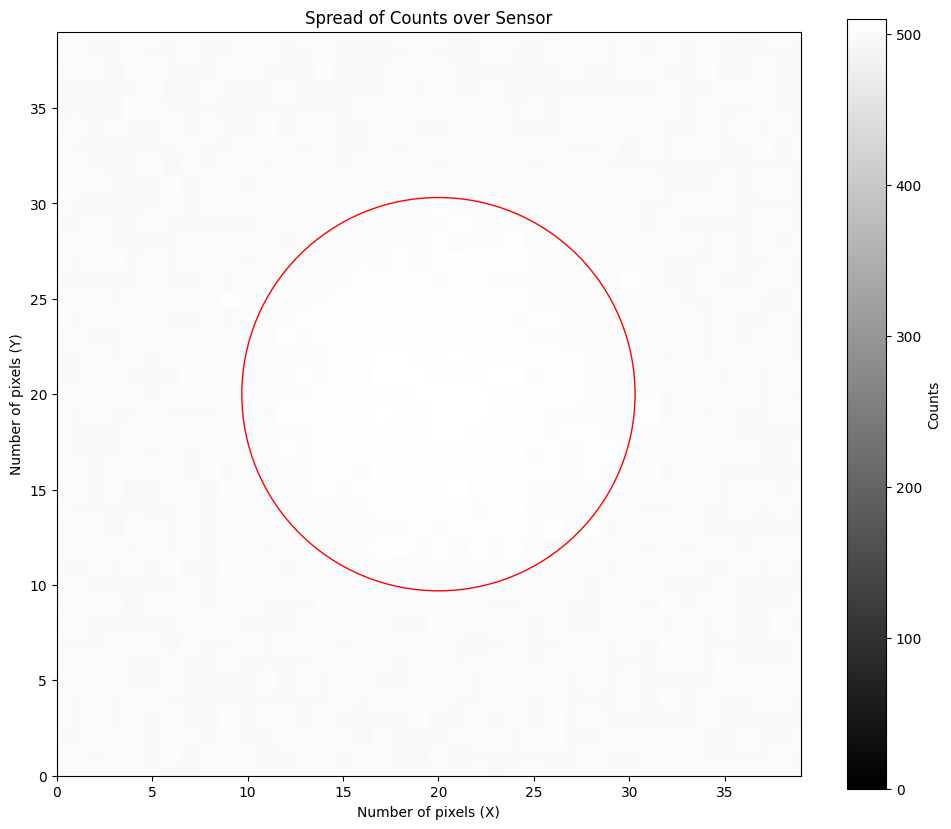

In [381]:
#GENERATE APERTURE FOR MEASURING SNR

aperture_rad = seeing_pixel*0.67
aperture_center = (sensor_X//2,sensor_Y//2)
aperture_num_pixels = np.pi*aperture_rad**2

#PLOT STAR AND APERTURE

aperture_circle = patches.Circle(aperture_center,radius=aperture_rad, edgecolor = 'red', facecolor = 'none', linewidth = 1)

plt.figure(figsize=(12, 10))


plt.imshow(final_sensor_array, cmap='gray', interpolation='nearest',vmin = 0)

plt.gca().add_patch(aperture_circle)
plt.colorbar(label='Counts')
plt.title('Spread of Counts over Sensor')
plt.xlabel('Number of pixels (X)')
plt.ylabel('Number of pixels (Y)')
plt.xlim(0,sensor_X-1)
plt.ylim(0,sensor_Y-1)
plt.gca().set_aspect('equal')
plt.show()

In [382]:
print("The peak number of counts in the simulated image is: ",np.max(final_sensor_array))
print("The minimum number of counts in the simulated image is: ",np.min(final_sensor_array))

The peak number of counts in the simulated image is:  510.2440180573073
The minimum number of counts in the simulated image is:  496.4230036111788


In [383]:
#COMPUTE NUMBER OF COUNTS WITHIN APERTURE

def countsInRad(sensorX,sensorY,signalGrid,radius):

    countsWithinRadius = 0

    for x in range(len(signalGrid)):
        for y in range(len(signalGrid[0])):

            if (np.sqrt((x-(sensorX//2))**2+(y-(sensorY//2))**2)) <= radius:

                countsWithinRadius = countsWithinRadius + signalGrid[x][y]

    return countsWithinRadius


In [384]:
counts_per_second = countsInRad(sensor_X,sensor_Y,signal_values,aperture_rad)

print(round(counts_per_second,2), "counts per second are recorded for signal to noise calculations.")
print(round(np.sum(signal_values),2), "counts per second are recorded from the star in total.")

1576.17 counts per second are recorded for signal to noise calculations.
2180.31 counts per second are recorded from the star in total.


In [385]:
def computeSNR(exposureTime, signalCountsPerSec=counts_per_second, apertureNumPixels=aperture_num_pixels, readNoise = read_noise, darkNoise = dark_noise, obsType=obs_type):


    if obsType == 1: # Point source

        return (signalCountsPerSec*exposureTime)/(np.sqrt(signalCountsPerSec*exposureTime+apertureNumPixels*(exposureTime*generateBG(sensor_X,sensor_Y,sky_bright,filter_name,mirror_area,gain,Q_efficiency,pixel_area,obs_type)+readNoise**2+exposureTime*darkNoise)))
    
    elif obsType == 0: # Extended

        return (signalCountsPerSec*exposureTime)/(np.sqrt(signalCountsPerSec*exposureTime+(exposureTime*generateBG(sensor_X,sensor_Y,sky_bright,filter_name,mirror_area,gain,Q_efficiency,pixel_area,obs_type)+readNoise**2+exposureTime*darkNoise)))
   

In [386]:
if obs_type == 1: # Point Source

    SNR_ref = (counts_per_second*test_exposure)/(np.sqrt(counts_per_second*test_exposure+aperture_num_pixels*(test_exposure*bg_values+read_noise**2+test_exposure*dark_noise)))
    print("The SNR of the reference image is: ", round(SNR_ref,2))

elif obs_type == 0: # Extended Source

    SNR_ref = (counts_per_second*test_exposure)/(np.sqrt(counts_per_second*test_exposure+(test_exposure*bg_values+read_noise**2+test_exposure*dark_noise)))
    print("The SNR of the reference image is: ", round(SNR_ref,2))   



The SNR of the reference image is:  34.74


In [387]:
#CHECK FOG LIMIT AND CALCULATE EXPOSURE TIME
#If a star is too dim or the sky too bright, SNR will plateau. This code checks to see if the desired SNR is above this limit. Assumes maximum exposure time of 300 hours.
#If Desired SNR is above the fog limit, a lower SNR must be input or better conditions observed.
#This function iterates over SNR calculations until the desired SNR is achieved within a tolerance, default Tolerance = 1

In [388]:
def calculateReqTime(desiredSNR, snrRef, expRef, tolerance = 1, maxTime = 1080000):
    
    maxSNR = computeSNR(maxTime)
    currentSNR = snrRef

    if desiredSNR>maxSNR:
        return "SNR not achievable"


    else:
        while np.abs(desiredSNR-currentSNR)>tolerance:
            currentTime = expRef*(desiredSNR/currentSNR)**2
            currentSNR = computeSNR(currentTime)
            expRef = currentTime
            print("SNR is now: ",round(currentSNR,2))
            
        return currentTime
        

The sensor receives: 0.012025710560836912 counts per second per pixel due to light pollution.


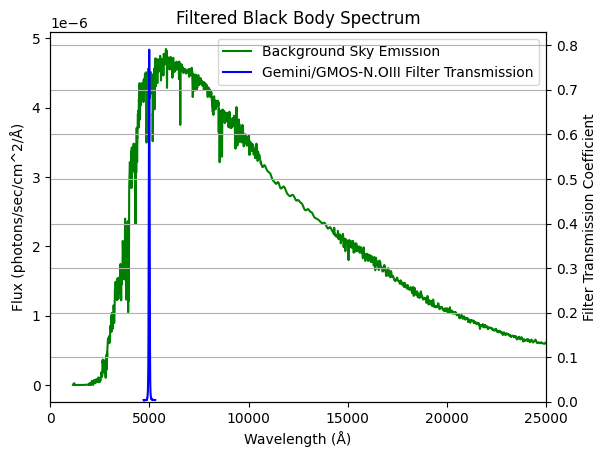

The sensor receives: 0.012025710560836912 counts per second per pixel due to light pollution.


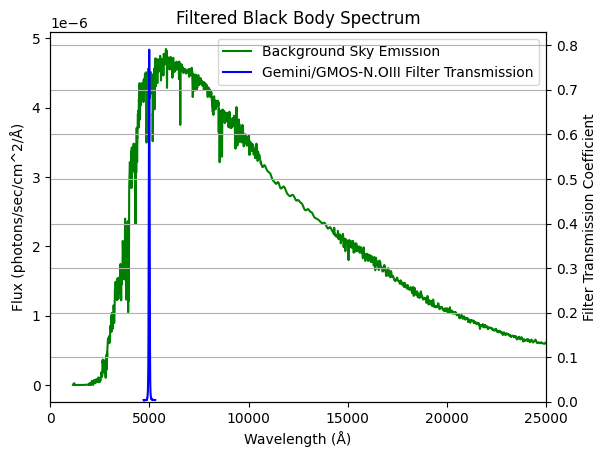

SNR is now:  5133.62
The sensor receives: 0.012025710560836912 counts per second per pixel due to light pollution.


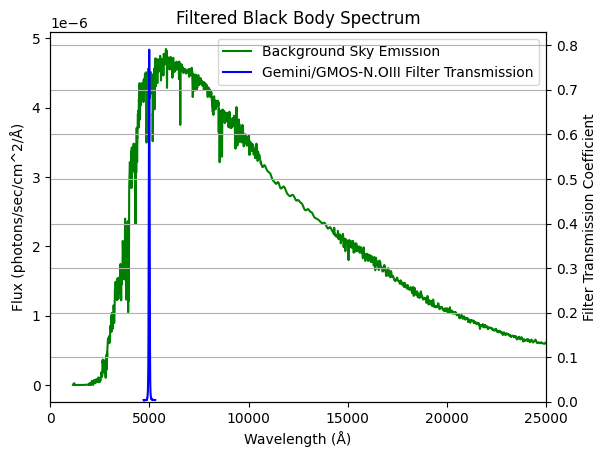

SNR is now:  4499.99
The calculated exposure time is:  12894.14 seconds.


In [389]:
#Calculate exposure time for desired SNR using function.
desired_SNR = 4500
required_Time = calculateReqTime(desired_SNR, SNR_ref, test_exposure)

print("The calculated exposure time is: ",round(required_Time,2), "seconds.")